# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import f
import random

# Dataset and Pre-Processing

In [ ]:

df1 = pd.read_excel('/content/scenario1_filtered.xlsx')
df2 = pd.read_excel('/content/Scenario2_filtered.xlsx')
df3 = pd.read_excel('/content/Scenario3_filtered.xlsx')
df4 = pd.read_excel('/content/Scenario4_filtered.xlsx')

In [ ]:
x1 = df1.to_numpy()
x2 = df2.to_numpy()
x3 = df3.to_numpy()
x4 = df4.to_numpy()

In [ ]:

dataset1 = x1.T
dataset2 = x2.T
dataset3 = x3.T
dataset4 = x4.T

In [ ]:
print(dataset1.shape)

(1501, 38)


In [ ]:
noise_level = 0.2
noise = np.random.normal(0, noise_level, dataset1.shape)


In [ ]:
dataset1_noisy = dataset1 + noise
dataset2_noisy = dataset2 + noise
dataset3_noisy = dataset3 + noise
dataset4_noisy = dataset4 + noise

# AEO Implementation

## Model Architecture

In [ ]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.001] = 0.001
    return (X - mu) / sigma, mu, sigma

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)

In [ ]:
class AutoencoderAEO(nn.Module):
  def __init__(self,input_dim,latent_dim=8):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim,16),
        nn.ReLU(),
        nn.Linear(16,latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,16),
        nn.ReLU(),
        nn.Linear(16,input_dim)
    )

  def forward(self,x):
    y = self.encoder(x)
    x_recon = self.decoder(y)
    return x_recon,y

In [ ]:
def aeo_loss(model,x,x_recon,y,Q,alpha=1.0,beta=0.5,gamma=0.1):
    j1=alpha*torch.mean((x-x_recon)**2)
    y0=(y-y.mean(0,keepdim=True)).T
    j2=beta*torch.trace(y0.T@Q@y0)
    j3=gamma*sum(p.pow(2).sum() for p in model.parameters())
    return j1+j2+j3, j1, j2, j3

In [ ]:
def tune_q_collect_variances(data, q_values, epochs=300, lr=1e-3):
    """
    For each q in q_values:
      -  Q = diag([0.1*q,1*q,2*q,3*q,4*q])
      - We will train the autoencoder on clean dataset
      - Find the ideal value of q were ordering would take place
      - Record latent variances for plotting and visualising
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X = torch.FloatTensor(data).to(device)
    input_dim = X.shape[1]
    latent_dim = 8
    latent_vars_matrix = []

    for q in q_values:
        # construct Q as specified
        weights = torch.FloatTensor([0.1*q, 1*q, 2*q, 3*q, 4*q,5*q,10*q,20*q]).to(device)
        Q = torch.diag(weights)

        # initialize model and optimizer
        model = AutoencoderAEO(input_dim,latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # train once on the data
        for epoches in range(epochs):
            x_recon, y = model(X)
            loss, _, _, _ = aeo_loss(model, X, x_recon, y, Q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoches%50==0:
             print(f"Epoch {epoches}, Loss: {loss.item()}")

        # collect variances of the latent code
        with torch.no_grad():
            y_out = model.encoder(X).cpu().numpy()
        vars_ = np.var(y_out, axis=0)
        latent_vars_matrix.append(vars_)

    return np.vstack(latent_vars_matrix)

In [ ]:
def plot_q_variances(latent_vars_matrix, q_values,scenario):
    """
    Plot variance of each latent dimension as a function of q.
    """
    plt.figure(figsize=(8,4))
    m = latent_vars_matrix.shape[1]
    for i in range(m):
        plt.plot(q_values, latent_vars_matrix[:, i], marker='o', label=f'Var(y{i+1})')
    plt.xlabel('q')
    plt.ylabel('Variance')
    plt.title(f'Ordered Latent Variances vs q for {scenario}')
    plt.xticks(q_values)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def aeo_monitoring_after_tuning(
    data, best_q,
    window_size=300,
    alpha=0.001,  # Significance level for Control Limit
    loss_alpha=1.0, # Tuning parameter for reconstruction
    beta=0.5,       # Tuning parameter for variance
    gamma=0.1,      # Tuning parameter for weights
    epochs=2000,
    lr=1e-3
):

    N, n = data.shape
    latent_dim = 8

    # 1. Prepare Data
    X0 = data[:window_size]
    Xn0, mu, sigma = normalize(X0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Xt0 = torch.FloatTensor(Xn0).to(device)
    weights = torch.FloatTensor([0, 1*best_q, 2*best_q, 3*best_q, 4*best_q,
                                 5*best_q, 10*best_q, 20*best_q]).to(device)
    Q = torch.diag(weights)

    model = AutoencoderAEO(n, latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # 2. Training Loop
    for ep in range(epochs):
        x_recon, y = model(Xt0)
        j1 = loss_alpha * torch.sum((Xt0 - x_recon)**2)

        # Variance Term
        y_centered = (y - y.mean(0, keepdim=True)).T
        j2 = beta * torch.trace(y_centered.T @ Q @ y_centered)

        # Weight Regularization
        j3 = gamma * sum(p.pow(2).sum() for p in model.parameters())

        loss = j1 + j2 + j3
        opt.zero_grad()
        loss.backward()
        opt.step()

        if ep % 500 == 0:
            print(f"Epoch {ep}, Loss: {loss.item():.4f}")

    # 3. Latent Space Analysis
    with torch.no_grad():
        _, Y0t = model(Xt0)

    Y0 = Y0t.cpu().numpy()

    # Determine 'p' (significant variables) based on cumulative variance
    variances = Y0.var(axis=0)
    total_var = variances.sum() + 1e-10
    cum_var = variances.cumsum() / total_var

    # Select p components that explain 90% variance
    p = max(2, int((cum_var < 0.99).sum()) + 1)
    print(f"Number of significant dimensions in latent space: {p}")

    # 4. Calculate Mahalanobis Parameters (Covariance of Latent Variables)
    Y0_centered = Y0[:, :p] - Y0[:, :p].mean(axis=0)
    covY = np.cov(Y0_centered.T) + 1e-6 * np.eye(p)
    Qy = np.linalg.inv(covY)

    # 5. Calculate Control Limit (F-Distribution)
    m_samples = window_size
    F_crit = f.ppf(1 - alpha, p, m_samples - p)
    Cl = (p * (m_samples - 1) * (m_samples + 1)) / (m_samples * (m_samples - p)) * F_crit

    # 6. Monitoring / Inference Loop
    T2 = np.zeros(N)
    detected = []

    model.eval() # Set to eval mode

    for k in range(window_size, N):
        xk_raw = (data[k] - mu) / sigma
        xk_tensor = torch.FloatTensor(xk_raw).unsqueeze(0).to(device)

        with torch.no_grad():
            _, yk_tensor = model(xk_tensor)
            yk = yk_tensor.cpu().numpy().flatten()

        # Select only p significant components
        yk_selected = yk[:p]

        # Center using TRAINING latent mean
        yk_centered = yk_selected - Y0[:, :p].mean(axis=0)

        # Calculate T2 Statistic
        # print(yk_centered.shape)
        T2[k] = yk_centered @ Qy @ yk_centered

        if T2[k] > Cl:
            detected.append(k)

    return T2, detected, Cl

In [ ]:
def aeo_monitoring_after_tuning_fsamples(
    data, best_q,
    window_size=300,
    alpha=0.001,  # Significance level for Control Limit
    loss_alpha=1.0, # Tuning parameter for reconstruction
    beta=0.5,       # Tuning parameter for variance
    gamma=0.1,      # Tuning parameter for weights
    epochs=2000,
    lr=1e-3
):
    set_seed(42)
    N, n = data.shape
    latent_dim = 8

    # 1. Prepare Data
    X0 = data[:window_size]
    Xn0, mu, sigma = normalize(X0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Xt0 = torch.FloatTensor(Xn0).to(device)
    weights = torch.FloatTensor([0, 1*best_q, 2*best_q, 3*best_q, 4*best_q,
                                 5*best_q, 10*best_q, 20*best_q]).to(device)
    Q = torch.diag(weights)

    model = AutoencoderAEO(n, latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # 2. Training Loop
    for ep in range(epochs):
        x_recon, y = model(Xt0)
        j1 = loss_alpha * torch.sum((Xt0 - x_recon)**2)

        # Variance Term
        y_centered = (y - y.mean(0, keepdim=True)).T
        j2 = beta * torch.trace(y_centered.T @ Q @ y_centered)

        # Weight Regularization
        j3 = gamma * sum(p.pow(2).sum() for p in model.parameters())

        loss = j1 + j2 + j3
        opt.zero_grad()
        loss.backward()
        opt.step()

        if ep % 500 == 0:
            print(f"Epoch {ep}, Loss: {loss.item():.4f}")

    # 3. Latent Space Analysis
    with torch.no_grad():
        _, Y0t = model(Xt0)

    Y0 = Y0t.cpu().numpy()

    # Determine significant variables in latent space
    variances = Y0.var(axis=0)
    total_var = variances.sum() + 1e-10
    cum_var = variances.cumsum() / total_var

    # Select p latent components explaining 90% variance
    p = max(2, int((cum_var < 0.9).sum()) + 1)
    print(f"Number of significant dimensions in latent space: {p}")

    # 4. Calculate Covariance and Mean for Mahalanobis
    Y0_selected = Y0[:, :p]
    Y0_mean = Y0_selected.mean(axis=0)

    covY = np.cov((Y0_selected - Y0_mean).T) + 1e-6 * np.eye(p)
    Qy = np.linalg.inv(covY)

    # 5. Calculate Control Limit using F-distribution
    m_samples = window_size
    F_crit = f.ppf(1 - alpha, p, m_samples - p)
    Cl = (p * (m_samples - 1) * (m_samples + 1)) / (m_samples * (m_samples - p)) * F_crit

    # 6. Monitoring / Inference Loop
    T2 = np.zeros(N)
    detected = []

    model.eval()

    # T² for first window samples (training period)
    for i in range(window_size):
        yi_centered = Y0_selected[i] - Y0_mean
        T2[i] = yi_centered @ Qy @ yi_centered

    # T² for remaining samples (monitoring)
    for k in range(window_size, N):
        xk_raw = (data[k] - mu) / sigma
        xk_tensor = torch.FloatTensor(xk_raw).unsqueeze(0).to(device)

        with torch.no_grad():
            _, yk_tensor = model(xk_tensor)
            yk = yk_tensor.cpu().numpy().flatten()

        yk_selected = yk[:p]
        yk_centered = yk_selected - Y0_mean


        T2[k] = yk_centered @ Qy @ yk_centered
        # print(yk_centered.shape)

        if T2[k] > Cl:
            detected.append(k)

    return T2, detected, Cl


## For Scenario1 Dataset

Epoch 0, Loss: 17652.2265625
Epoch 50, Loss: 15091.4970703125
Epoch 100, Loss: 4547.85986328125
Epoch 150, Loss: 291.4864807128906
Epoch 200, Loss: 29.78461456298828
Epoch 250, Loss: 25.109542846679688
Epoch 300, Loss: 18.877037048339844
Epoch 350, Loss: 13.982733726501465
Epoch 400, Loss: 9.949840545654297
Epoch 450, Loss: 7.3788838386535645
Epoch 500, Loss: 6.082444667816162
Epoch 550, Loss: 5.284804821014404
Epoch 600, Loss: 4.945904731750488
Epoch 650, Loss: 4.511166095733643
Epoch 700, Loss: 4.141092300415039
Epoch 750, Loss: 6.284694671630859
Epoch 800, Loss: 3.9376883506774902
Epoch 850, Loss: 2.322248935699463
Epoch 900, Loss: 1.7570010423660278
Epoch 950, Loss: 1.628498911857605
Epoch 1000, Loss: 1.588416576385498
Epoch 1050, Loss: 1.5597283840179443
Epoch 1100, Loss: 1.5428937673568726
Epoch 1150, Loss: 1.5282869338989258
Epoch 1200, Loss: 1.5149991512298584
Epoch 1250, Loss: 1.5014195442199707
Epoch 1300, Loss: 1.4881067276000977
Epoch 1350, Loss: 1.4758981466293335
Epoch 14

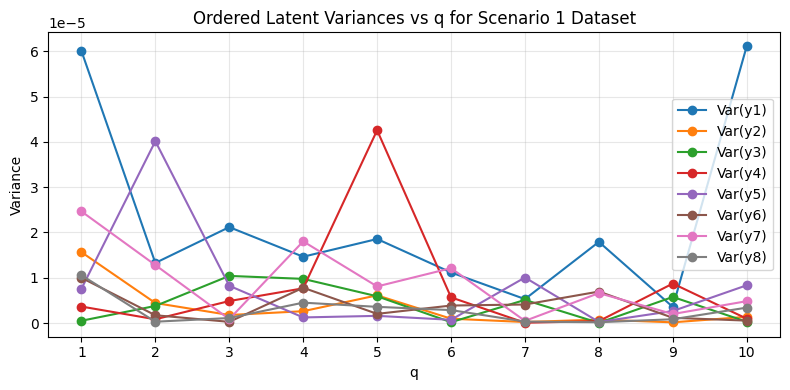

In [ ]:
q_values = list(range(1,11))
latent_vars = tune_q_collect_variances(dataset1,q_values,epochs=2000,lr=1e-3)
plot_q_variances(latent_vars,q_values,'Scenario 1 Dataset')

Epoch 0, Loss: 5510.5869
Epoch 500, Loss: 63.0676
Epoch 1000, Loss: 44.8246
Epoch 1500, Loss: 38.5189
Epoch 2000, Loss: 37.0051
Epoch 2500, Loss: 35.2120
Epoch 3000, Loss: 32.6815
Epoch 3500, Loss: 31.7969
Epoch 4000, Loss: 34.0259
Epoch 4500, Loss: 35.6489
Number of significant dimensions in latent space: 2
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


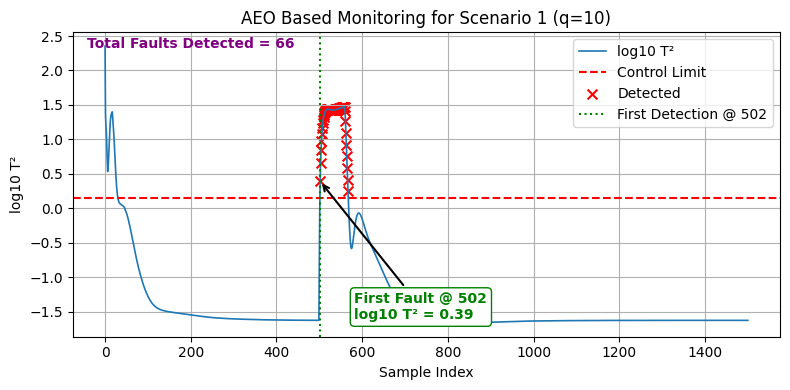

In [ ]:

best_q = 10
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset1, best_q, window_size=300, alpha=0.5, epochs=5000, lr=5e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')
if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 1 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 5572.6602
Epoch 500, Loss: 146.2213
Epoch 1000, Loss: 65.2050
Epoch 1500, Loss: 44.1405
Epoch 2000, Loss: 38.7636
Epoch 2500, Loss: 36.3214
Epoch 3000, Loss: 34.6957
Epoch 3500, Loss: 32.7265
Epoch 4000, Loss: 33.1233
Epoch 4500, Loss: 30.8352
Epoch 5000, Loss: 30.2686
Epoch 5500, Loss: 29.8798
Epoch 6000, Loss: 29.4646
Epoch 6500, Loss: 29.0966
Epoch 7000, Loss: 28.8447
Epoch 7500, Loss: 28.5881
Epoch 8000, Loss: 28.4387
Epoch 8500, Loss: 30.4163
Epoch 9000, Loss: 27.8867
Epoch 9500, Loss: 27.6949
Number of significant dimensions in latent space: 2
Detected by AEO at: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567]
Total faults detected: 66


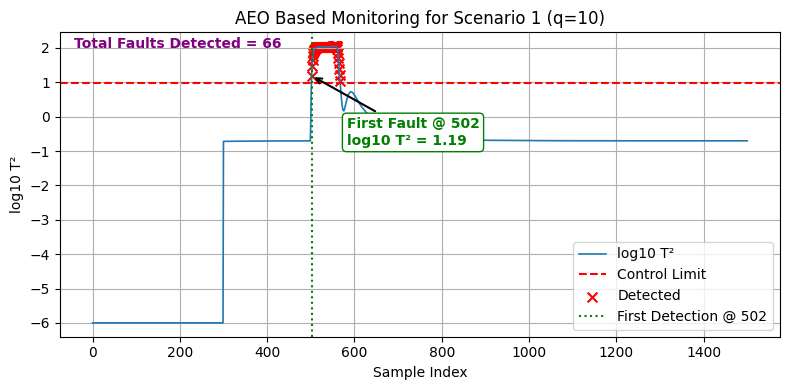

In [ ]:

best_q = 10
T2_scores, detected, control_limit = aeo_monitoring_after_tuning(
    dataset1, best_q, window_size=300, alpha=0.01, epochs=10000, lr=2e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')
if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 1 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### For Noisy Scenario 1 Dataset

Epoch 0, Loss: 17570.484375
Epoch 50, Loss: 7850.51025390625
Epoch 100, Loss: 90.24818420410156
Epoch 150, Loss: 25.8416805267334
Epoch 200, Loss: 22.639698028564453
Epoch 250, Loss: 16.809280395507812
Epoch 300, Loss: 13.778504371643066
Epoch 350, Loss: 12.386516571044922
Epoch 400, Loss: 11.65271282196045
Epoch 450, Loss: 11.212607383728027
Epoch 500, Loss: 10.880303382873535
Epoch 550, Loss: 10.584088325500488
Epoch 600, Loss: 9.50484848022461
Epoch 650, Loss: 8.337876319885254
Epoch 700, Loss: 7.5664191246032715
Epoch 750, Loss: 7.017791748046875
Epoch 800, Loss: 6.632176399230957
Epoch 850, Loss: 6.298977851867676
Epoch 900, Loss: 6.037607669830322
Epoch 950, Loss: 5.832988739013672
Epoch 1000, Loss: 5.686035633087158
Epoch 1050, Loss: 5.522556304931641
Epoch 1100, Loss: 5.398098468780518
Epoch 1150, Loss: 5.283053398132324
Epoch 1200, Loss: 5.178943157196045
Epoch 1250, Loss: 5.084109783172607
Epoch 1300, Loss: 4.993156909942627
Epoch 1350, Loss: 4.909350395202637
Epoch 1400, Los

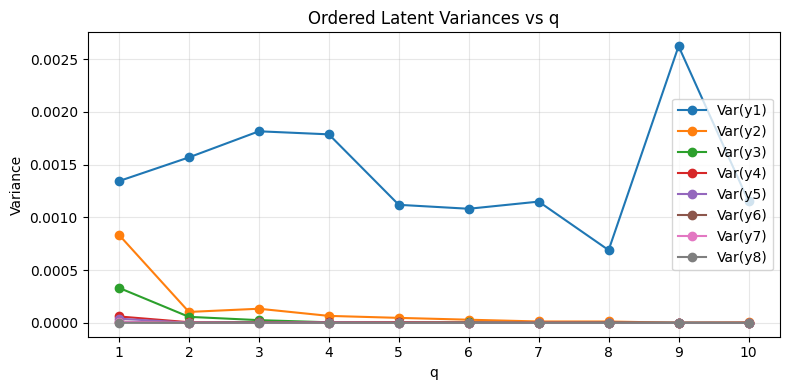

In [ ]:
q_values = list(range(1,11))
latent_vars = tune_q_collect_variances(dataset1_noisy,q_values,epochs=2000,lr=1e-3)
plot_q_variances(latent_vars,q_values)

Epoch 0, Loss: 13344.8711
Epoch 500, Loss: 7432.4541
Epoch 1000, Loss: 7061.1978
Epoch 1500, Loss: 7231.5786
Epoch 2000, Loss: 7055.3018
Epoch 2500, Loss: 7096.1221
Epoch 3000, Loss: 6909.9800
Epoch 3500, Loss: 6817.0049
Epoch 4000, Loss: 6888.8154
Epoch 4500, Loss: 6800.0972
Epoch 5000, Loss: 6826.4277
Epoch 5500, Loss: 6813.9736
Epoch 6000, Loss: 6786.3740
Epoch 6500, Loss: 6824.3413
Epoch 7000, Loss: 6782.3325
Epoch 7500, Loss: 6776.1533
Epoch 8000, Loss: 6762.5674
Epoch 8500, Loss: 7030.3228
Epoch 9000, Loss: 6765.6431
Epoch 9500, Loss: 6728.4912
Number of significant dimensions in latent space: 2
Detected by AEO at: [325, 371, 514, 563, 584, 763, 789, 838, 954, 974, 991, 1009, 1136, 1142, 1166, 1196, 1229, 1255, 1342, 1367, 1422, 1426, 1454, 1455]
Total faults detected: 24


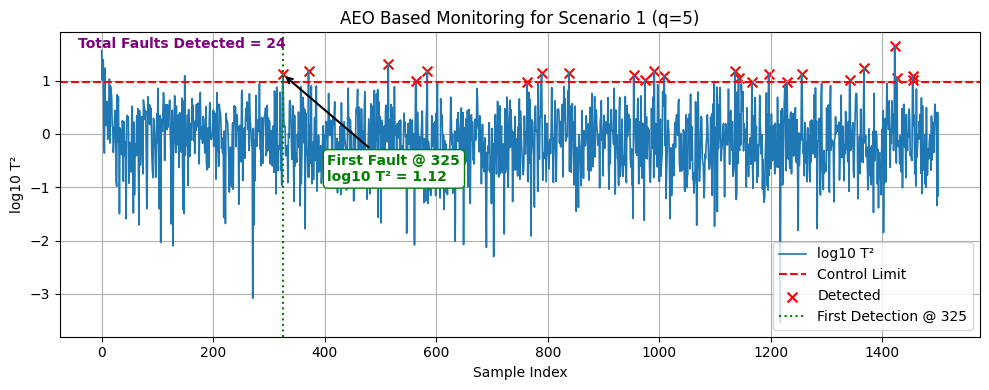

In [ ]:

best_q = 5
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset1_noisy, best_q, window_size=300, alpha=0.01, epochs=10000, lr=5e-2
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(10, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 1 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## For Scenario2 Datsaset

Epoch 0, Loss: 17845.373046875
Epoch 50, Loss: 9060.8642578125
Epoch 100, Loss: 311.75604248046875
Epoch 150, Loss: 7.577516078948975
Epoch 200, Loss: 5.674605369567871
Epoch 250, Loss: 4.949287414550781
Epoch 300, Loss: 3.560253143310547
Epoch 350, Loss: 2.9652512073516846
Epoch 400, Loss: 2.735132932662964
Epoch 450, Loss: 2.643414258956909
Epoch 500, Loss: 2.385680913925171
Epoch 550, Loss: 2.2637898921966553
Epoch 600, Loss: 2.235905170440674
Epoch 650, Loss: 2.2129788398742676
Epoch 700, Loss: 2.19264817237854
Epoch 750, Loss: 2.1732239723205566
Epoch 800, Loss: 2.1548240184783936
Epoch 850, Loss: 2.1370272636413574
Epoch 900, Loss: 2.119816780090332
Epoch 950, Loss: 2.1031486988067627
Epoch 1000, Loss: 2.0875885486602783
Epoch 1050, Loss: 2.0713324546813965
Epoch 1100, Loss: 2.05633544921875
Epoch 1150, Loss: 2.0429513454437256
Epoch 1200, Loss: 2.0269484519958496
Epoch 1250, Loss: 2.012801170349121
Epoch 1300, Loss: 2.0026113986968994
Epoch 1350, Loss: 1.9855976104736328
Epoch 1

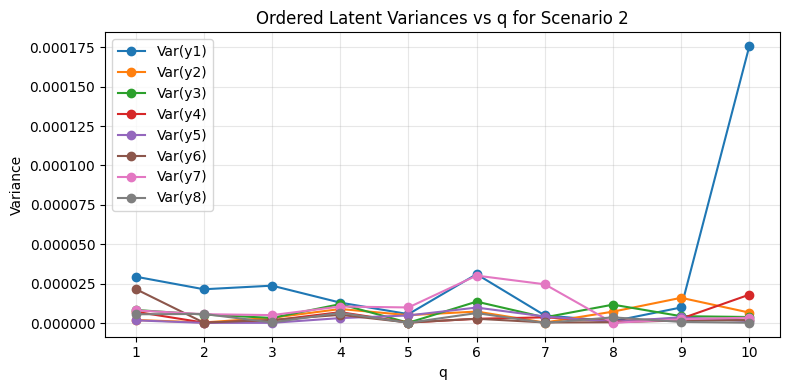

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset2, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values,'Scenario 2')


Epoch 0, Loss: 5510.5869
Epoch 500, Loss: 233.4497
Epoch 1000, Loss: 71.4805
Epoch 1500, Loss: 50.0620
Epoch 2000, Loss: 43.3157
Epoch 2500, Loss: 40.4828
Epoch 3000, Loss: 38.8782
Epoch 3500, Loss: 36.4168
Epoch 4000, Loss: 35.4553
Epoch 4500, Loss: 35.2007
Number of significant dimensions in latent space: 2
Detected by AEO at: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635

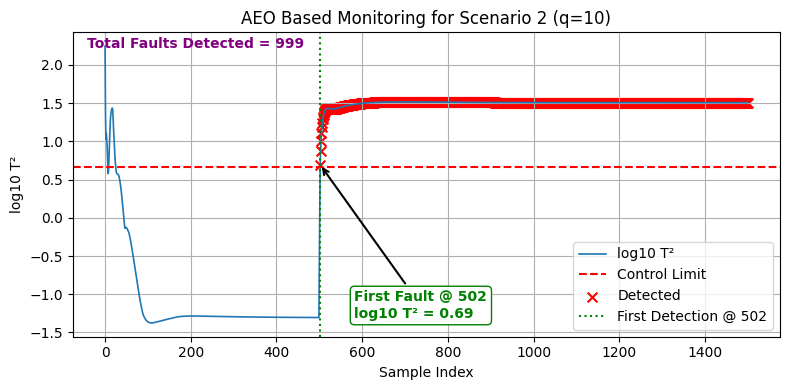

In [ ]:

best_q = 10
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset2, best_q, window_size=300, alpha=0.1, epochs=5000, lr=2e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(8, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 2 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 17571.8984375
Epoch 50, Loss: 7861.54248046875
Epoch 100, Loss: 87.12771606445312
Epoch 150, Loss: 23.79248046875
Epoch 200, Loss: 21.908384323120117
Epoch 250, Loss: 20.782743453979492
Epoch 300, Loss: 18.17696762084961
Epoch 350, Loss: 12.719127655029297
Epoch 400, Loss: 11.62059497833252
Epoch 450, Loss: 11.171211242675781
Epoch 500, Loss: 10.887980461120605
Epoch 550, Loss: 10.645001411437988
Epoch 600, Loss: 10.412249565124512
Epoch 650, Loss: 10.181146621704102
Epoch 700, Loss: 9.414555549621582
Epoch 750, Loss: 8.301794052124023
Epoch 800, Loss: 7.44468355178833
Epoch 850, Loss: 6.899440765380859
Epoch 900, Loss: 6.525529861450195
Epoch 950, Loss: 6.267032623291016
Epoch 1000, Loss: 6.039857864379883
Epoch 1050, Loss: 5.856484413146973
Epoch 1100, Loss: 5.703543186187744
Epoch 1150, Loss: 5.560827732086182
Epoch 1200, Loss: 5.448042869567871
Epoch 1250, Loss: 5.324184894561768
Epoch 1300, Loss: 5.219512462615967
Epoch 1350, Loss: 5.121380805969238
Epoch 1400, Loss

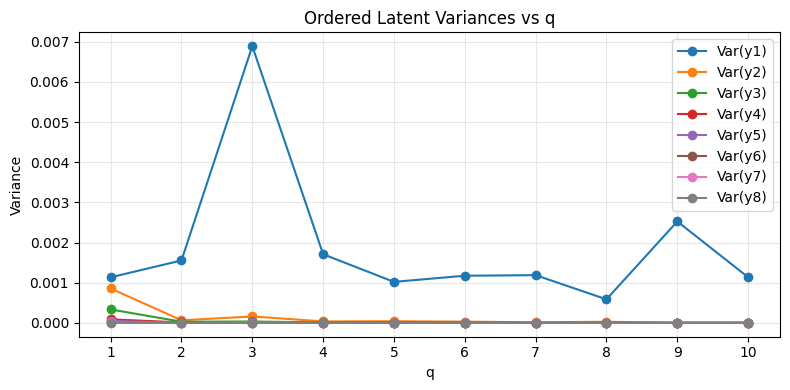

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset2_noisy, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values)


Epoch 0, Loss: 14541.3379
Epoch 500, Loss: 7794.7461
Epoch 1000, Loss: 6935.3589
Epoch 1500, Loss: 6709.8262
Epoch 2000, Loss: 6623.9258
Epoch 2500, Loss: 6572.5156
Epoch 3000, Loss: 6546.7959
Epoch 3500, Loss: 6530.5537
Epoch 4000, Loss: 6516.1758
Epoch 4500, Loss: 6500.1846
Epoch 5000, Loss: 6479.9087
Epoch 5500, Loss: 6442.7461
Epoch 6000, Loss: 6382.4258
Epoch 6500, Loss: 6341.2969
Epoch 7000, Loss: 6305.6978
Epoch 7500, Loss: 6282.6543
Epoch 8000, Loss: 6265.8965
Epoch 8500, Loss: 6245.8315
Epoch 9000, Loss: 6234.7822
Epoch 9500, Loss: 6225.2988
Number of significant dimensions in latent space: 2
Detected by AEO at: [435, 512, 526, 534, 535, 554, 556, 570, 578, 580, 583, 590, 599, 602, 608, 611, 613, 617, 624, 627, 630, 635, 653, 661, 664, 673, 675, 684, 685, 691, 693, 702, 708, 710, 720, 721, 726, 727, 764, 773, 794, 796, 800, 802, 808, 813, 823, 824, 825, 827, 828, 854, 859, 861, 863, 864, 884, 898, 908, 916, 932, 933, 936, 943, 944, 949, 956, 961, 962, 963, 967, 971, 976, 988, 

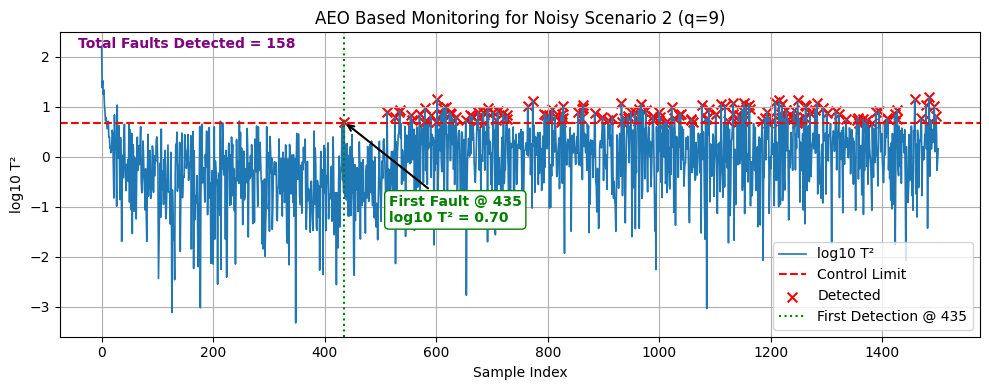

In [ ]:

best_q = 9
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset2_noisy, best_q, window_size=300, alpha=0.1, epochs=10000, lr=2e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(10, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Noisy Scenario 2 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## For Scenario 3 Dataset

Epoch 0, Loss: 17618.955078125
Epoch 50, Loss: 8077.341796875
Epoch 100, Loss: 149.3282928466797
Epoch 150, Loss: 32.16654968261719
Epoch 200, Loss: 20.935014724731445
Epoch 250, Loss: 14.339399337768555
Epoch 300, Loss: 6.707366943359375
Epoch 350, Loss: 5.320418834686279
Epoch 400, Loss: 4.890836715698242
Epoch 450, Loss: 4.6161298751831055
Epoch 500, Loss: 4.363814353942871
Epoch 550, Loss: 4.002603054046631
Epoch 600, Loss: 3.617868423461914
Epoch 650, Loss: 3.316357135772705
Epoch 700, Loss: 3.061065912246704
Epoch 750, Loss: 2.8801419734954834
Epoch 800, Loss: 2.677826404571533
Epoch 850, Loss: 2.5422725677490234
Epoch 900, Loss: 2.435945510864258
Epoch 950, Loss: 2.3633744716644287
Epoch 1000, Loss: 2.332062005996704
Epoch 1050, Loss: 2.2731165885925293
Epoch 1100, Loss: 2.2434182167053223
Epoch 1150, Loss: 2.2189435958862305
Epoch 1200, Loss: 2.1999564170837402
Epoch 1250, Loss: 2.179548501968384
Epoch 1300, Loss: 2.1626791954040527
Epoch 1350, Loss: 2.1457462310791016
Epoch 14

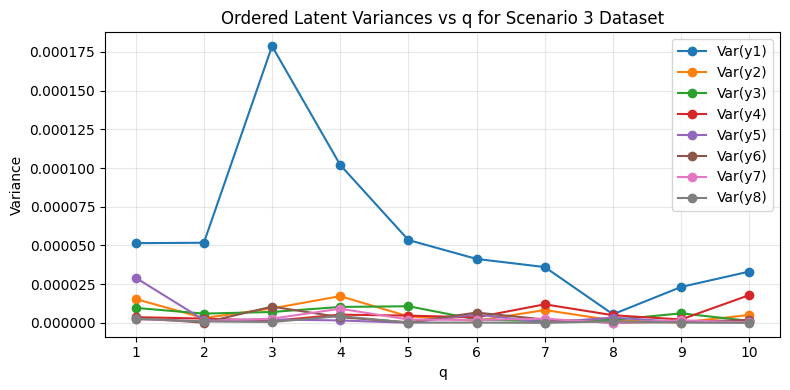

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset3, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values,"Scenario 3 Dataset")


Epoch 0, Loss: 4787.1187
Epoch 500, Loss: 57.7981
Epoch 1000, Loss: 37.6152
Epoch 1500, Loss: 33.0840
Epoch 2000, Loss: 31.2511
Epoch 2500, Loss: 30.2592
Epoch 3000, Loss: 30.1541
Epoch 3500, Loss: 28.4465
Epoch 4000, Loss: 27.5278
Epoch 4500, Loss: 27.0633
Epoch 5000, Loss: 27.0148
Epoch 5500, Loss: 26.9222
Epoch 6000, Loss: 26.5143
Epoch 6500, Loss: 40.7729
Epoch 7000, Loss: 26.6829
Epoch 7500, Loss: 25.3793
Epoch 8000, Loss: 27.0124
Epoch 8500, Loss: 25.0294
Epoch 9000, Loss: 24.6407
Epoch 9500, Loss: 25.0180
Number of significant dimensions in latent space: 2
Detected by AEO at: [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 585, 586,

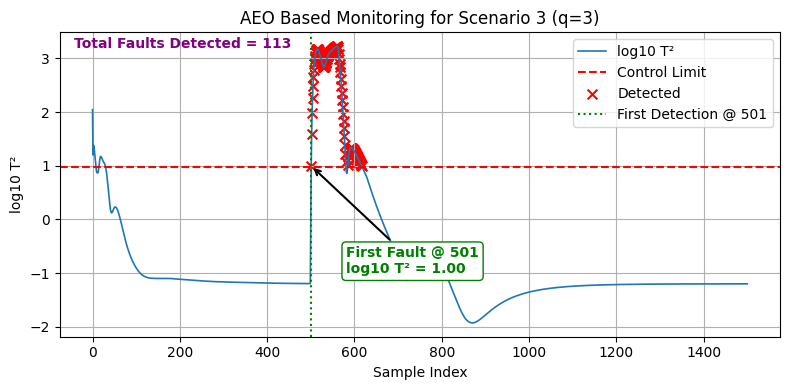

In [ ]:

best_q = 3
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset3, best_q, window_size=300, alpha=0.01, epochs=10000, lr=5e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(8, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')
if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 3 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 17623.94140625
Epoch 50, Loss: 8093.62841796875
Epoch 100, Loss: 169.1897430419922
Epoch 150, Loss: 44.25922393798828
Epoch 200, Loss: 33.0466423034668
Epoch 250, Loss: 28.38092041015625
Epoch 300, Loss: 24.010791778564453
Epoch 350, Loss: 17.268863677978516
Epoch 400, Loss: 14.010954856872559
Epoch 450, Loss: 11.884979248046875
Epoch 500, Loss: 10.427711486816406
Epoch 550, Loss: 9.020894050598145
Epoch 600, Loss: 8.179848670959473
Epoch 650, Loss: 7.656466484069824
Epoch 700, Loss: 7.299128532409668
Epoch 750, Loss: 7.038876533508301
Epoch 800, Loss: 6.871179580688477
Epoch 850, Loss: 6.619266986846924
Epoch 900, Loss: 6.45008659362793
Epoch 950, Loss: 6.259942531585693
Epoch 1000, Loss: 6.056525230407715
Epoch 1050, Loss: 5.887149810791016
Epoch 1100, Loss: 5.764065742492676
Epoch 1150, Loss: 5.657517433166504
Epoch 1200, Loss: 5.55958366394043
Epoch 1250, Loss: 5.46809196472168
Epoch 1300, Loss: 5.380404472351074
Epoch 1350, Loss: 5.299226760864258
Epoch 1400, Loss: 

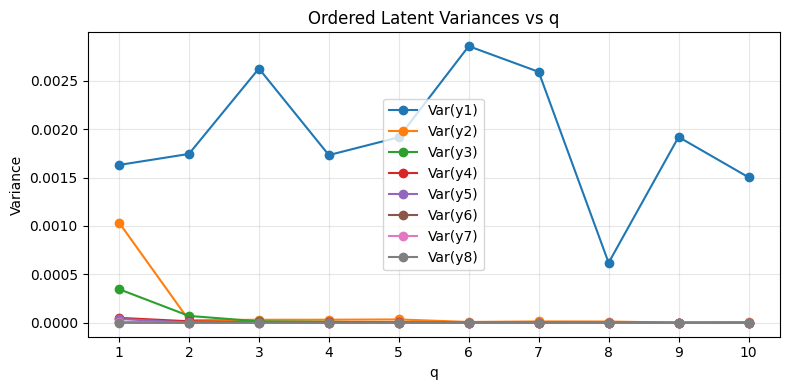

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset3_noisy, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values)


Epoch 0, Loss: 13574.6885
Epoch 500, Loss: 6973.1191
Epoch 1000, Loss: 6646.3691
Epoch 1500, Loss: 6436.9746
Epoch 2000, Loss: 6319.9355
Epoch 2500, Loss: 6268.0874
Epoch 3000, Loss: 6245.5220
Epoch 3500, Loss: 6229.0293
Epoch 4000, Loss: 6219.8765
Epoch 4500, Loss: 6209.9893
Epoch 5000, Loss: 6206.0947
Epoch 5500, Loss: 6197.0244
Epoch 6000, Loss: 6189.9731
Epoch 6500, Loss: 6184.6313
Epoch 7000, Loss: 6180.4170
Epoch 7500, Loss: 6144.1929
Epoch 8000, Loss: 6104.4375
Epoch 8500, Loss: 6094.0869
Epoch 9000, Loss: 6081.6616
Epoch 9500, Loss: 6073.3926
Number of significant dimensions in latent space: 2
Detected by AEO at: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 

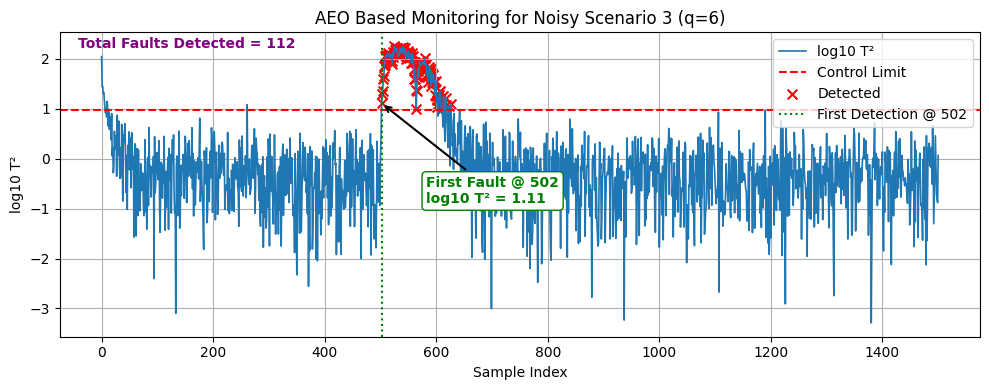

In [ ]:

best_q = 6
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset3_noisy, best_q, window_size=300, alpha=0.01, epochs=10000, lr=5e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))
plt.figure(figsize=(10, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')


plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Noisy Scenario 3 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## For Scenario 4 Dataset

Epoch 0, Loss: 17869.857421875
Epoch 50, Loss: 9023.7001953125
Epoch 100, Loss: 140.9147186279297
Epoch 150, Loss: 28.237751007080078
Epoch 200, Loss: 21.618545532226562
Epoch 250, Loss: 18.089492797851562
Epoch 300, Loss: 15.691107749938965
Epoch 350, Loss: 13.914810180664062
Epoch 400, Loss: 11.11495304107666
Epoch 450, Loss: 9.90589714050293
Epoch 500, Loss: 7.288546562194824
Epoch 550, Loss: 4.78987979888916
Epoch 600, Loss: 3.9927544593811035
Epoch 650, Loss: 3.5610766410827637
Epoch 700, Loss: 3.357754707336426
Epoch 750, Loss: 3.256923198699951
Epoch 800, Loss: 3.1851537227630615
Epoch 850, Loss: 3.2319934368133545
Epoch 900, Loss: 3.162027359008789
Epoch 950, Loss: 3.125852108001709
Epoch 1000, Loss: 3.094736099243164
Epoch 1050, Loss: 3.0661826133728027
Epoch 1100, Loss: 3.039170742034912
Epoch 1150, Loss: 3.014333724975586
Epoch 1200, Loss: 2.9904139041900635
Epoch 1250, Loss: 2.968820810317993
Epoch 1300, Loss: 2.9484331607818604
Epoch 1350, Loss: 2.925616979598999
Epoch 140

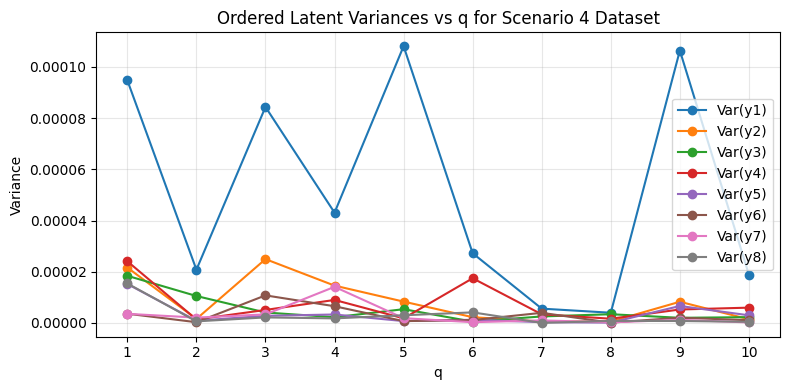

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset4, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values,"Scenario 4 Dataset")


Epoch 0, Loss: 4993.8242
Epoch 500, Loss: 170.7663
Epoch 1000, Loss: 55.4671
Epoch 1500, Loss: 42.2269
Epoch 2000, Loss: 37.3367
Epoch 2500, Loss: 35.1421
Epoch 3000, Loss: 33.9637
Epoch 3500, Loss: 33.0445
Epoch 4000, Loss: 32.5708
Epoch 4500, Loss: 32.0200
Number of significant dimensions in latent space: 2
Detected by AEO at: [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634

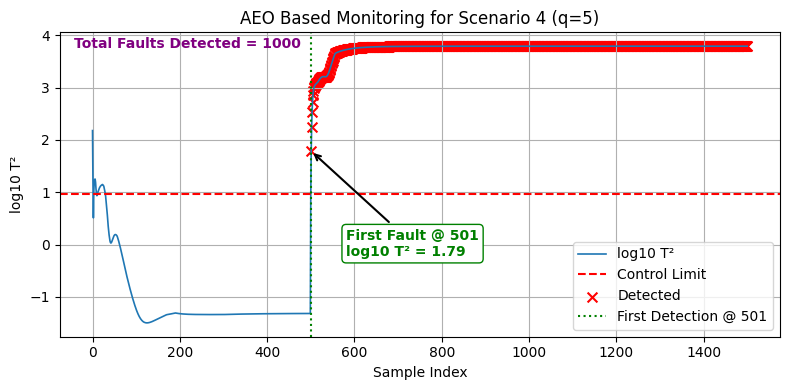

In [ ]:

best_q = 5
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset4, best_q, window_size=300, alpha=0.01, epochs=5000, lr=2e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(8, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 4 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 18340.640625
Epoch 50, Loss: 10097.8125
Epoch 100, Loss: 401.75390625
Epoch 150, Loss: 26.105806350708008
Epoch 200, Loss: 20.156129837036133
Epoch 250, Loss: 16.40990447998047
Epoch 300, Loss: 15.130675315856934
Epoch 350, Loss: 14.458525657653809
Epoch 400, Loss: 12.180785179138184
Epoch 450, Loss: 8.830491065979004
Epoch 500, Loss: 7.203187465667725
Epoch 550, Loss: 6.236076831817627
Epoch 600, Loss: 5.674901008605957
Epoch 650, Loss: 5.294551372528076
Epoch 700, Loss: 5.051077842712402
Epoch 750, Loss: 4.860957145690918
Epoch 800, Loss: 4.695866107940674
Epoch 850, Loss: 4.567690849304199
Epoch 900, Loss: 4.453402042388916
Epoch 950, Loss: 4.348480701446533
Epoch 1000, Loss: 4.277606964111328
Epoch 1050, Loss: 4.189732074737549
Epoch 1100, Loss: 4.122315406799316
Epoch 1150, Loss: 4.058030605316162
Epoch 1200, Loss: 3.996838331222534
Epoch 1250, Loss: 3.9385595321655273
Epoch 1300, Loss: 3.883312463760376
Epoch 1350, Loss: 3.834808826446533
Epoch 1400, Loss: 3.787277

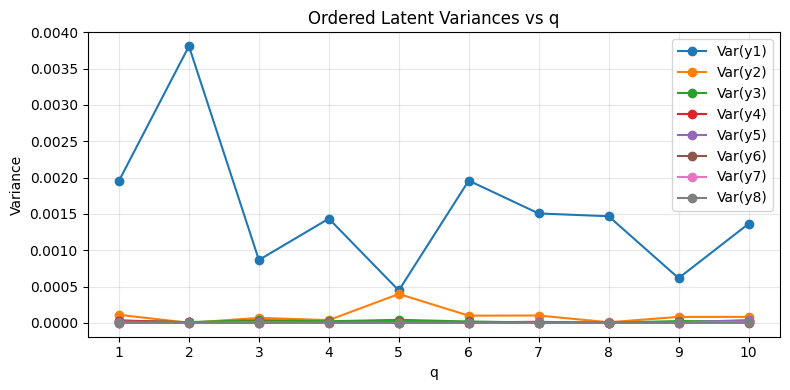

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset4_noisy, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values)


Epoch 0, Loss: 12285.8232
Epoch 500, Loss: 6529.7202
Epoch 1000, Loss: 6286.9937
Epoch 1500, Loss: 6224.0791
Epoch 2000, Loss: 6196.0342
Epoch 2500, Loss: 6172.2197
Epoch 3000, Loss: 6150.2046
Epoch 3500, Loss: 6143.9844
Epoch 4000, Loss: 6132.1758
Epoch 4500, Loss: 6126.3110
Epoch 5000, Loss: 6121.4717
Epoch 5500, Loss: 6116.4907
Epoch 6000, Loss: 6111.0576
Epoch 6500, Loss: 6106.0249
Epoch 7000, Loss: 6104.7925
Epoch 7500, Loss: 6074.8701
Epoch 8000, Loss: 6067.9531
Epoch 8500, Loss: 6075.8315
Epoch 9000, Loss: 6056.1890
Epoch 9500, Loss: 6046.2930
Number of significant dimensions in latent space: 2
Detected by AEO at: [507, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 

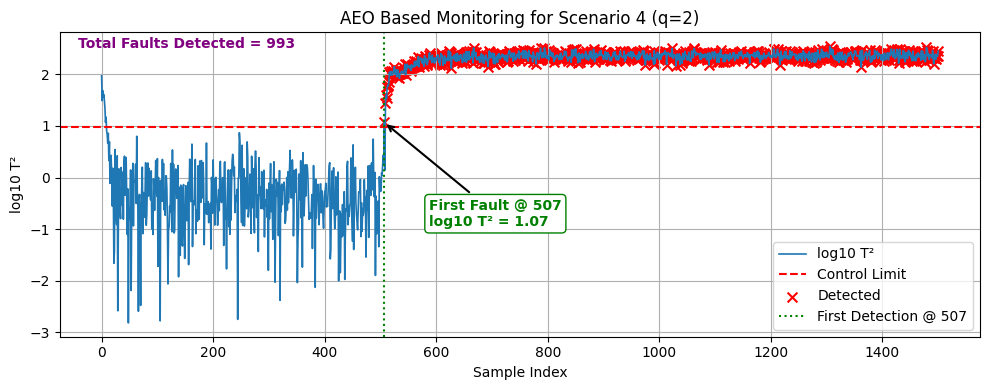

In [ ]:

best_q = 2
T2_scores, detected, control_limit = aeo_monitoring_after_tuning_fsamples(
    dataset4_noisy, best_q, window_size=300, alpha=0.01, epochs=10000, lr=5e-3
)

print("Detected by AEO at:", detected)
print("Total faults detected:", len(detected))

plt.figure(figsize=(10, 4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')

plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', s=50, label='Detected')

if len(detected) > 0:
    first_detected = detected[0]
    first_value = np.log10(T2_scores[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Based Monitoring for Scenario 4 (q={best_q})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PCA Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from numpy.linalg import eig, inv

In [ ]:
def train_pca(Xn, Vpc):
    C = np.cov(Xn, rowvar=False)
    vals, vecs = eig(C)
    idx = np.argsort(vals)[::-1]
    vals, vecs = vals[idx], vecs[:, idx]
    cum = np.cumsum(vals) / vals.sum() * 100
    Np = np.searchsorted(cum, Vpc) + 1
    Pp = vecs[:, :Np]
    Y = Xn.dot(Pp)
    return Np, Pp, vals[:Np], Y

In [ ]:
def compute_control_limit(Np, Nw, alpha=0.01):
    """
    Control limit Cl based on F-distribution:
      Cl = (Np*(Nw-1)*(Nw+1)) / (Nw*(Nw-Np)) * F(1-alpha; Np, Nw-Np)
    """
    Fcrit = f.ppf(1-alpha, Np, Nw-Np)
    Cl = (Np*(Nw-1)*(Nw+1)) / (Nw*(Nw-Np)) * Fcrit
    return Cl

### For Scenario1

/tmp/ipython-input-65969262.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-65969262.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562]
Total detected: 57


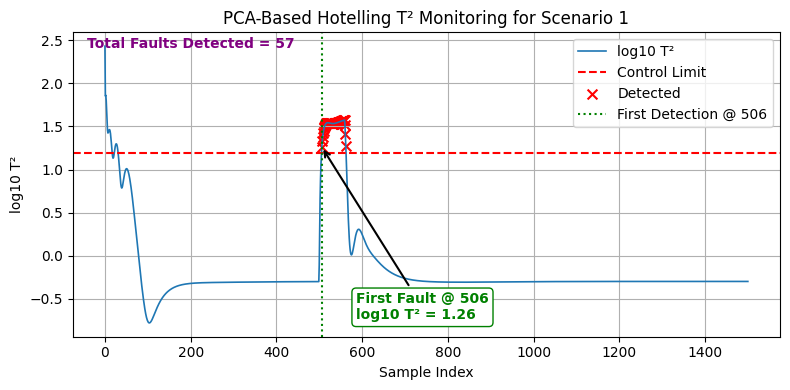

In [ ]:

window_size = 300    # initial PCA training window
Vpc         = 99   # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset1[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

# --- T² for the first window samples ---
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# --- T² for remaining samples (monitoring) ---
for k in range(window_size, N):
    x_norm = (dataset1[k] - mu) / sigma
    yk = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Scenario 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Detected anomalies at indices: [409, 416, 463, 517, 723, 751, 1096, 1120, 1132, 1205, 1389, 1470, 1498]
Total detected: 13


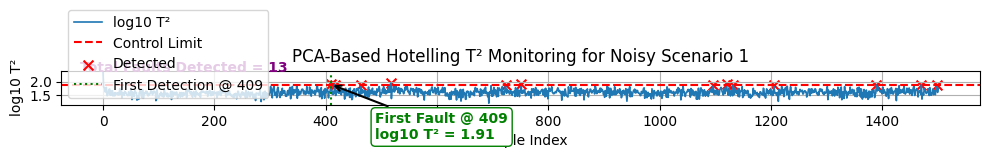

In [ ]:

window_size = 300    # initial PCA training window
Vpc         = 99    # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset1_noisy[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

# --- T² for the first window samples ---
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# --- T² for remaining samples (monitoring) ---
for k in range(window_size, N):
    x_norm = (dataset1_noisy[k] - mu) / sigma
    yk = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(10, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Noisy Scenario 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### For Scenario 2

/tmp/ipython-input-3888882579.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-3888882579.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699

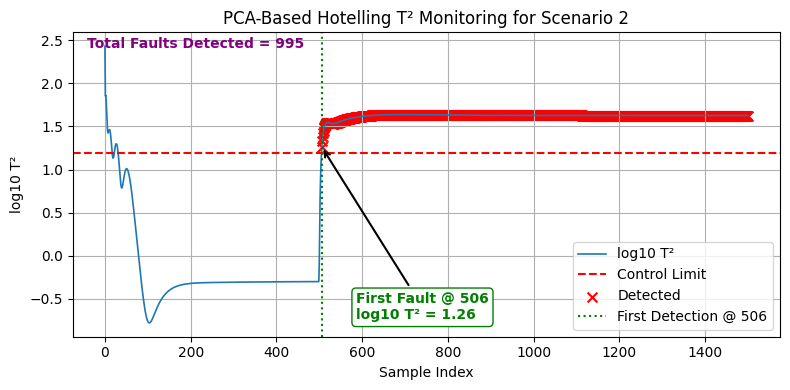

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300    # initial PCA training window
Vpc         = 99     # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset2[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# --- T² for remaining samples (monitoring) ---
for k in range(window_size, N):
    x_norm = (dataset2[k] - mu) / sigma
    yk = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Scenario 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Detected anomalies at indices: [409, 416, 463, 517, 591, 596, 669, 678, 697, 717, 723, 751, 778, 795, 801, 836, 841, 846, 884, 897, 905, 906, 1013, 1033, 1042, 1056, 1069, 1070, 1096, 1120, 1124, 1132, 1148, 1205, 1229, 1235, 1301, 1326, 1342, 1389, 1392, 1401, 1416, 1426, 1430, 1439, 1448, 1456, 1457, 1470, 1482, 1491, 1497, 1498]
Total detected: 54


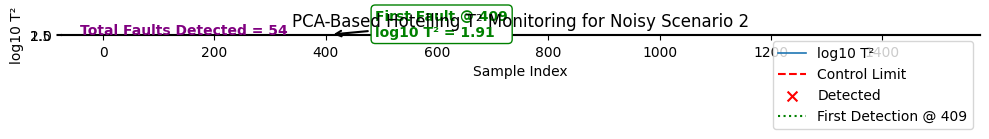

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300    # initial PCA training window
Vpc         = 99   # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset2_noisy[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# Inference on remaining samples
for k in range(window_size, N):
    x_norm = (dataset2_noisy[k] - mu) / sigma
    yk      = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2      = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2
    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(10, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Noisy Scenario 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## For Scenario 3

/tmp/ipython-input-4187027152.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-4187027152.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695

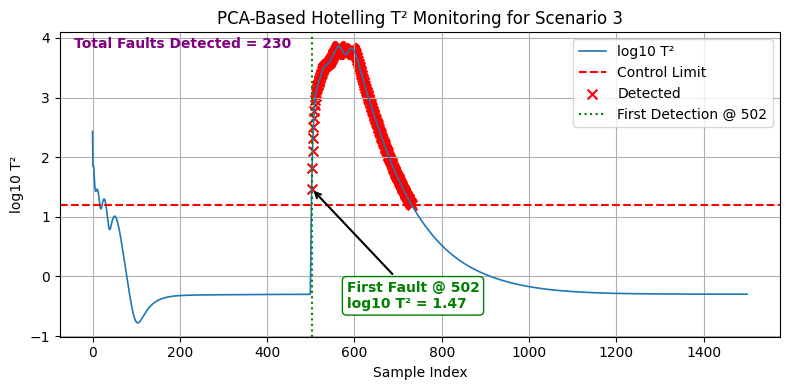

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300    # initial PCA training window
Vpc         = 99     # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset3[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# --- T² for remaining samples (monitoring) ---
for k in range(window_size, N):
    x_norm = (dataset3[k] - mu) / sigma
    yk = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Scenario 3')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## For Scenario 4

/tmp/ipython-input-1713286059.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-1713286059.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695

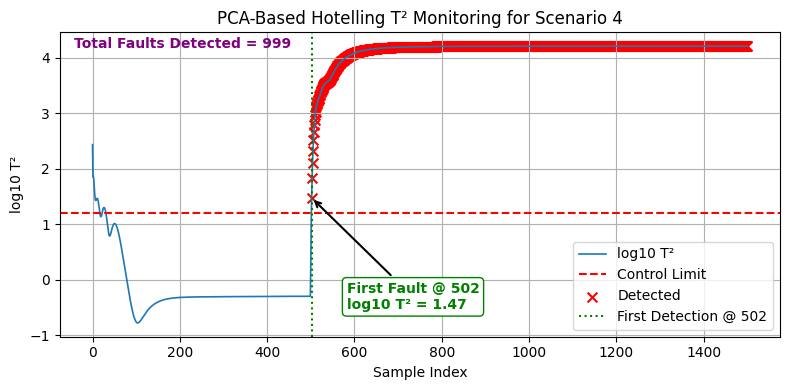

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300    # initial PCA training window
Vpc         = 99   # percent variance to retain
alpha       = 0.01   # significance level

N, D = dataset2.shape

# Train PCA on first window
X1     = dataset4[:window_size, :]
X1n, mu, sigma = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)   # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window
Ts2_all = np.empty(N)
detected = []

for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# --- T² for remaining samples (monitoring) ---
for k in range(window_size, N):
    x_norm = (dataset4[k] - mu) / sigma
    yk = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# --- Enhanced Plot ---
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

# ✅ Scatter all detected points (red crosses)
if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    # First detected point
    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    # Green vertical dotted line
    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    # Annotate the first detection with an arrow
    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),                # exact fault location
                 xytext=(first_detected + 80, first_value - 2),  # shifted annotation
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Annotate total detected faults
plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

# Final plot labels, legend, grid
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring for Scenario 4')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

yk_centered = np.array([5.0, 3.0])
Qy = np.array([[14.0, 13.0],
               [15.0, 21.0]])

print(yk_centered.shape)
print(Qy.shape)
T2_1 = yk_centered @ Qy @ yk_centered
T2_2 = yk_centered.T @ Qy @ yk_centered
T2_3 = (yk_centered.reshape(1,2) @ Qy @ yk_centered.reshape(2,1))

print("T2_1:", T2_1, "shape:", np.shape(T2_1))
print("T2_2:", T2_2, "shape:", np.shape(T2_2))
print("T2_3:", T2_3, "shape:", np.shape(T2_3))


(2,)
(2, 2)
T2_1: 959.0 shape: ()
T2_2: 959.0 shape: ()
T2_3: [[959.]] shape: (1, 1)


## RBCTk AEO Version

### Using Reconstructed Output

In [ ]:
# ===============================
# Imports
# ===============================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from scipy.stats import f

# ===============================
# Utilities
# ===============================
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.001] = 0.001
    return (X - mu) / sigma, mu, sigma

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# ===============================
# AEO Model
# ===============================
class AutoencoderAEO(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        x_recon = self.decoder(y)
        return x_recon, y

# ===============================
# AEO Loss
# ===============================
def aeo_loss(model, x, x_recon, y, Q, alpha=1.0, beta=0.5, gamma=0.1):
    j1 = alpha * torch.mean((x - x_recon) ** 2)
    y0 = (y - y.mean(0, keepdim=True)).T
    j2 = beta * torch.trace(y0.T @ Q @ y0)
    j3 = gamma * sum(p.pow(2).sum() for p in model.parameters())
    return j1 + j2 + j3

# ===============================
# RBCT for AEO (NEW PART)
# ===============================
def aeo_rbct(xk_norm, xk_recon, eps=1e-8):
    """
    Reconstruction-Based Contribution for AEO
    """
    err = (xk_norm - xk_recon) ** 2
    return err / (np.sum(err) + eps)

# ===============================
# q Tuning
# ===============================
def tune_q_collect_variances(data, q_values, epochs=300, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X = torch.FloatTensor(data).to(device)
    input_dim = X.shape[1]
    latent_dim = 8
    latent_vars_matrix = []

    for q in q_values:
        weights = torch.FloatTensor(
            [0.1*q, 1*q, 2*q, 3*q, 4*q, 5*q, 10*q, 20*q]
        ).to(device)
        Q = torch.diag(weights)

        model = AutoencoderAEO(input_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for ep in range(epochs):
            x_recon, y = model(X)
            loss = aeo_loss(model, X, x_recon, y, Q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            y_out = model.encoder(X).cpu().numpy()
        latent_vars_matrix.append(np.var(y_out, axis=0))

    return np.vstack(latent_vars_matrix)

def plot_q_variances(latent_vars_matrix, q_values, scenario):
    plt.figure(figsize=(8, 4))
    for i in range(latent_vars_matrix.shape[1]):
        plt.plot(q_values, latent_vars_matrix[:, i], marker='o', label=f'Var(y{i+1})')
    plt.xlabel('q')
    plt.ylabel('Variance')
    plt.title(f'Ordered Latent Variances vs q ({scenario})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===============================
# AEO Monitoring + RBCT
# ===============================
def aeo_monitoring_after_tuning_fsamples(
    data, best_q,
    window_size=300,
    alpha=0.01,
    loss_alpha=1.0,
    beta=0.5,
    gamma=0.1,
    epochs=2000,
    lr=1e-3
):
    set_seed(42)
    N, n = data.shape
    latent_dim = 8

    # ----- Training Data -----
    X0 = data[:window_size]
    Xn0, mu, sigma = normalize(X0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Xt0 = torch.FloatTensor(Xn0).to(device)

    weights = torch.FloatTensor(
        [0, 1*best_q, 2*best_q, 3*best_q, 4*best_q, 5*best_q, 10*best_q, 20*best_q]
    ).to(device)
    Q = torch.diag(weights)

    model = AutoencoderAEO(n, latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # ----- Train AEO -----
    for ep in range(epochs):
        x_recon, y = model(Xt0)
        j1 = loss_alpha * torch.sum((Xt0 - x_recon) ** 2)
        y_centered = (y - y.mean(0, keepdim=True)).T
        j2 = beta * torch.trace(y_centered.T @ Q @ y_centered)
        j3 = gamma * sum(p.pow(2).sum() for p in model.parameters())
        loss = j1 + j2 + j3
        opt.zero_grad()
        loss.backward()
        opt.step()
        if ep % 500 == 0:
            print(f"Epoch {ep}, Loss: {loss.item()}")


    # ----- Latent Stats -----
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.cpu().numpy()

    variances = Y0.var(axis=0)
    cum_var = np.cumsum(variances) / (np.sum(variances) + 1e-10)
    p = max(2, int((cum_var < 0.9).sum()) + 1)

    Y0p = Y0[:, :p]
    Y0_mean = Y0p.mean(axis=0)
    covY = np.cov((Y0p - Y0_mean).T) + 1e-6 * np.eye(p)
    Qy = np.linalg.inv(covY)

    F_crit = f.ppf(1 - alpha, p, window_size - p)
    Cl = (p * (window_size - 1) * (window_size + 1)) / \
         (window_size * (window_size - p)) * F_crit

    # ----- Monitoring -----
    T2 = np.zeros(N)
    detected = []
    RBCT = {}

    model.eval()

    for i in range(window_size):
        yi = Y0p[i] - Y0_mean
        T2[i] = yi @ Qy @ yi

    for k in range(window_size, N):
        xk_norm = (data[k] - mu) / sigma
        xk_tensor = torch.FloatTensor(xk_norm).unsqueeze(0).to(device)

        with torch.no_grad():
            xk_recon_t, yk_t = model(xk_tensor)

        yk = yk_t.cpu().numpy().flatten()[:p]
        yk_centered = yk - Y0_mean
        T2[k] = yk_centered @ Qy @ yk_centered

        if T2[k] > Cl:
            detected.append(k)

            xk_recon = xk_recon_t.cpu().numpy().flatten()
            RBCT[k] = aeo_rbct(xk_norm, xk_recon)

    return T2, detected, Cl, RBCT




#### Scenario 1

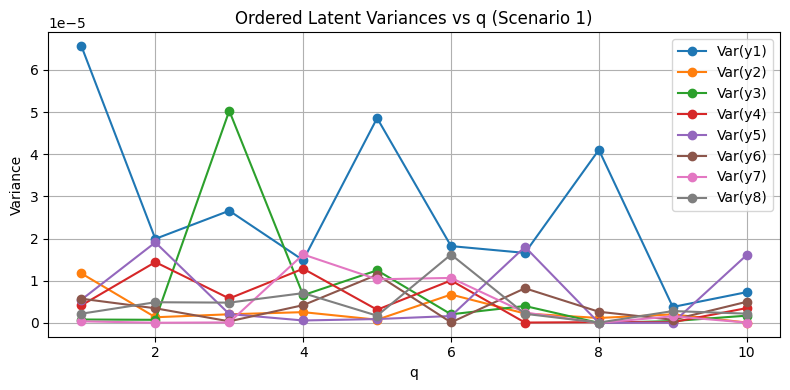

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(dataset1, q_values, epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values, 'Scenario 1')

Epoch 0, Loss: 4993.82421875
Epoch 500, Loss: 170.31906127929688
Epoch 1000, Loss: 55.55768966674805
Epoch 1500, Loss: 42.46892547607422
Epoch 2000, Loss: 37.572654724121094
Epoch 2500, Loss: 35.3101921081543
Epoch 3000, Loss: 33.95953369140625
Epoch 3500, Loss: 34.82134246826172
Epoch 4000, Loss: 32.30133056640625
Epoch 4500, Loss: 31.63204002380371
Epoch 5000, Loss: 31.317182540893555
Epoch 5500, Loss: 33.15772247314453
Epoch 6000, Loss: 30.51799201965332
Epoch 6500, Loss: 30.24094581604004
Epoch 7000, Loss: 29.99427032470703
Epoch 7500, Loss: 29.637962341308594
Epoch 8000, Loss: 30.065738677978516
Epoch 8500, Loss: 29.222545623779297
Epoch 9000, Loss: 29.32492446899414
Epoch 9500, Loss: 29.07074737548828
Epoch 10000, Loss: 28.77393341064453
Epoch 10500, Loss: 28.88091468811035
Epoch 11000, Loss: 28.50923728942871
Epoch 11500, Loss: 28.34127426147461
Epoch 12000, Loss: 28.390281677246094
Epoch 12500, Loss: 28.13943862915039
Epoch 13000, Loss: 28.023807525634766
Epoch 13500, Loss: 28.

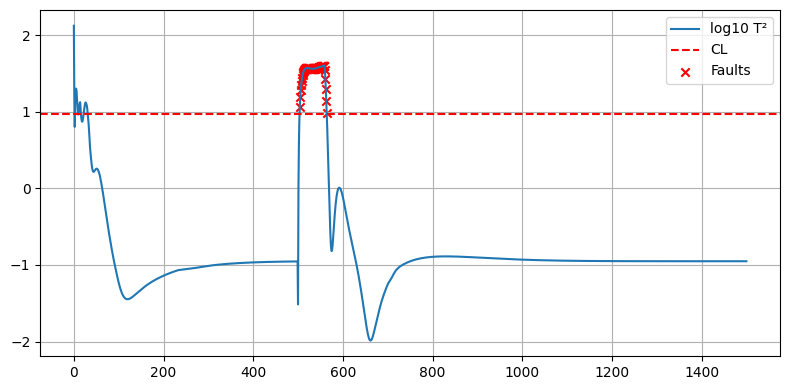

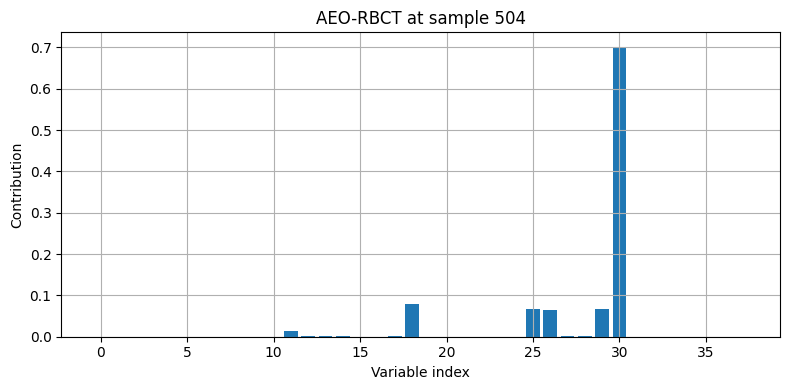

In [ ]:



best_q = 5
T2_scores, detected, Cl, RBCT = aeo_monitoring_after_tuning_fsamples(
    dataset1, best_q, window_size=300, alpha=0.01, epochs=20000, lr=2e-3
)

print("Detected faults:", detected)
print("Total detected:", len(detected))

# ----- Plot T² -----
plt.figure(figsize=(8,4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='CL')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', label='Faults')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- Plot RBCT for first detected fault -----
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(RBCT[k])), RBCT[k])
    plt.title(f"AEO-RBCT at sample {k}")
    plt.xlabel("Variable index")
    plt.ylabel("Contribution")
    plt.grid()
    plt.tight_layout()
    plt.show()

#### Scenario 2

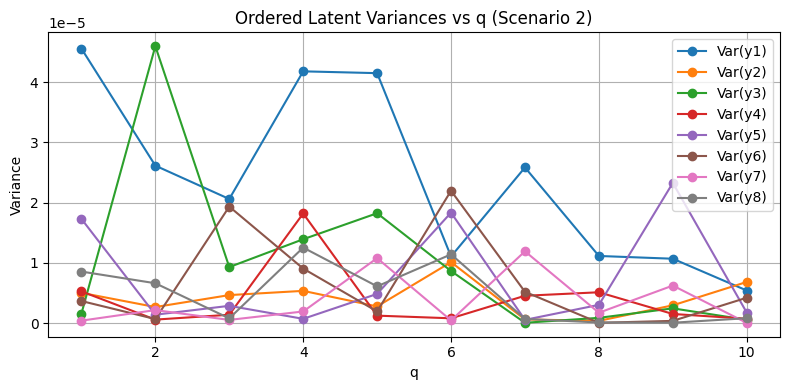

In [ ]:

latent_vars = tune_q_collect_variances(dataset2, q_values, epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values, 'Scenario 2')

Epoch 0, Loss: 4890.4716796875
Epoch 500, Loss: 37.719261169433594
Epoch 1000, Loss: 33.72371292114258
Epoch 1500, Loss: 32.12906265258789
Epoch 2000, Loss: 32.58163070678711
Epoch 2500, Loss: 31.2330322265625
Epoch 3000, Loss: 28.63711166381836
Epoch 3500, Loss: 31.642345428466797
Epoch 4000, Loss: 27.209455490112305
Epoch 4500, Loss: 27.85068130493164
Epoch 5000, Loss: 26.315887451171875
Epoch 5500, Loss: 38.5104866027832
Epoch 6000, Loss: 27.479921340942383
Epoch 6500, Loss: 26.043489456176758
Epoch 7000, Loss: 25.471359252929688
Epoch 7500, Loss: 26.520503997802734
Epoch 8000, Loss: 25.33248519897461
Epoch 8500, Loss: 24.399024963378906
Epoch 9000, Loss: 25.744800567626953
Epoch 9500, Loss: 23.81310272216797
Detected faults: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 

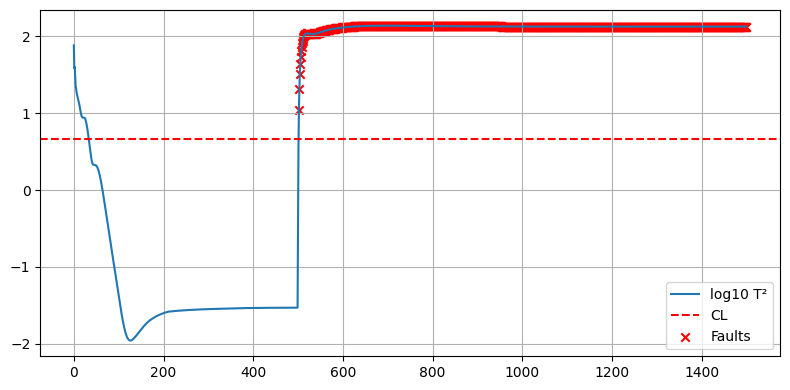

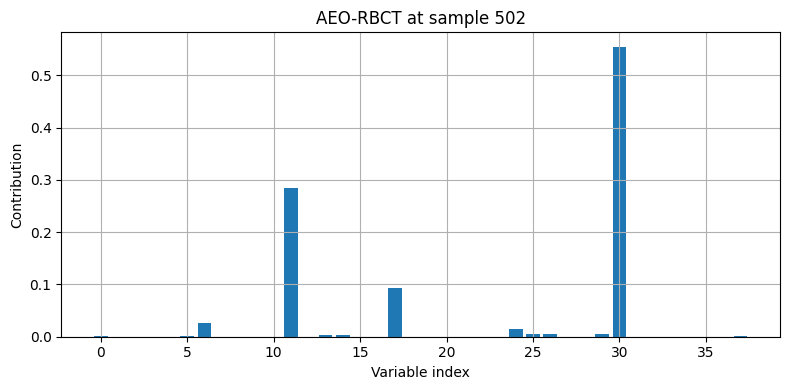

In [ ]:



best_q = 4
T2_scores, detected, Cl, RBCT = aeo_monitoring_after_tuning_fsamples(
    dataset2, best_q, window_size=300, alpha=0.1, epochs=10000, lr=2e-2
)

print("Detected faults:", detected)
print("Total detected:", len(detected))

# ----- Plot T² -----
plt.figure(figsize=(8,4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='CL')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', label='Faults')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- Plot RBCT for first detected fault -----
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(RBCT[k])), RBCT[k])
    plt.title(f"AEO-RBCT at sample {k}")
    plt.xlabel("Variable index")
    plt.ylabel("Contribution")
    plt.grid()
    plt.tight_layout()
    plt.show()

#### Scenario 3

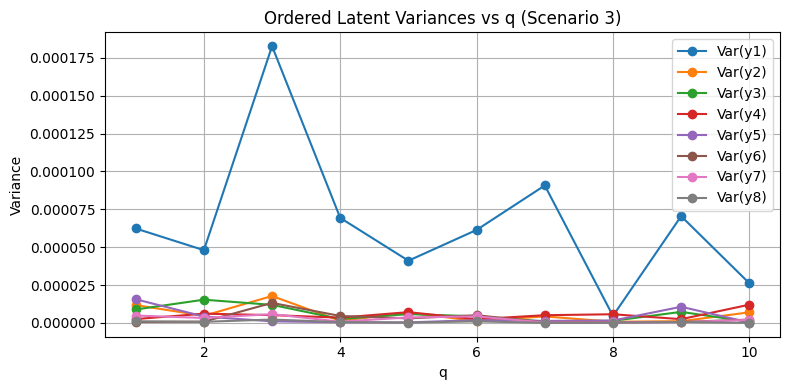

In [ ]:

latent_vars = tune_q_collect_variances(dataset3, q_values, epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values, 'Scenario 3')

Epoch 0, Loss: 4787.11865234375
Epoch 500, Loss: 56.84715270996094
Epoch 1000, Loss: 36.52860641479492
Epoch 1500, Loss: 32.509429931640625
Epoch 2000, Loss: 44.441898345947266
Epoch 2500, Loss: 29.833534240722656
Epoch 3000, Loss: 28.903499603271484
Epoch 3500, Loss: 28.990144729614258
Epoch 4000, Loss: 27.84970474243164
Epoch 4500, Loss: 26.991336822509766
Detected faults: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625]
Total detec

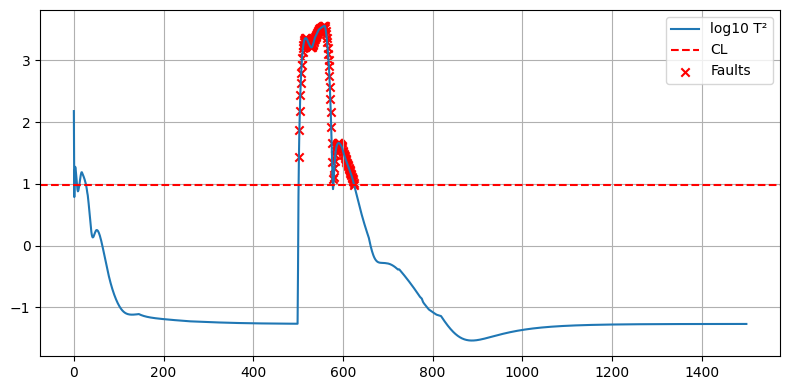

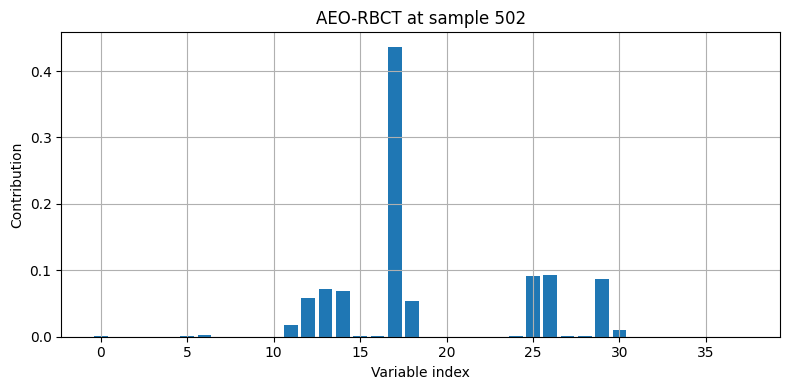

In [ ]:



best_q = 3
T2_scores, detected, Cl, RBCT = aeo_monitoring_after_tuning_fsamples(
    dataset3, best_q, window_size=300, alpha=0.01, epochs=5000, lr=5e-3
)

print("Detected faults:", detected)
print("Total detected:", len(detected))

# ----- Plot T² -----
plt.figure(figsize=(8,4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='CL')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', label='Faults')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- Plot RBCT for first detected fault -----
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(RBCT[k])), RBCT[k])
    plt.title(f"AEO-RBCT at sample {k}")
    plt.xlabel("Variable index")
    plt.ylabel("Contribution")
    plt.grid()
    plt.tight_layout()
    plt.show()

#### Scenario 4

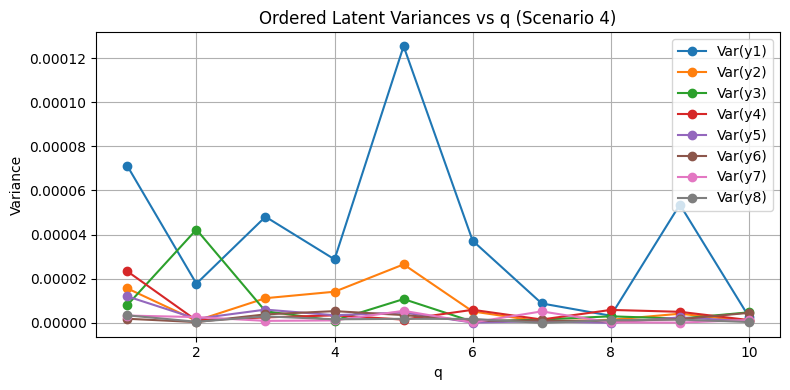

In [ ]:

latent_vars = tune_q_collect_variances(dataset4, q_values, epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values, 'Scenario 4')

Epoch 0, Loss: 4993.82421875
Epoch 500, Loss: 65.42343139648438
Epoch 1000, Loss: 42.64804458618164
Epoch 1500, Loss: 39.22328186035156
Epoch 2000, Loss: 35.69373321533203
Epoch 2500, Loss: 34.37226104736328
Epoch 3000, Loss: 33.02098083496094
Epoch 3500, Loss: 32.915260314941406
Epoch 4000, Loss: 32.95307159423828
Epoch 4500, Loss: 31.970069885253906
Detected faults: [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626

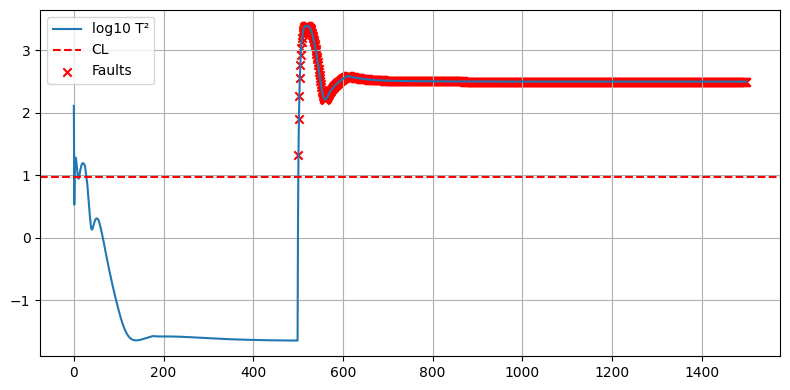

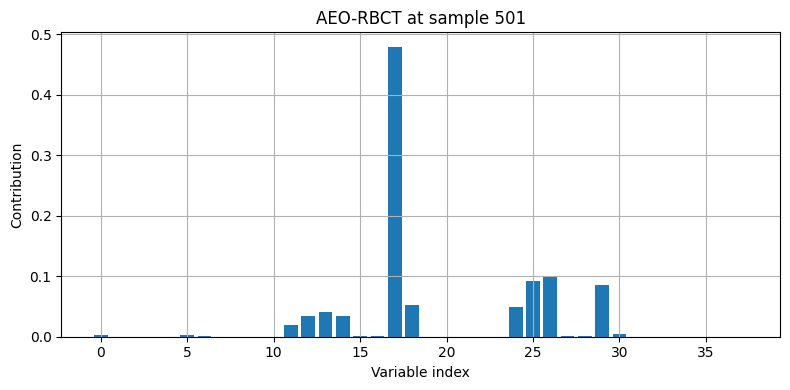

In [ ]:



best_q = 5
T2_scores, detected, Cl, RBCT = aeo_monitoring_after_tuning_fsamples(
    dataset4, best_q, window_size=300, alpha=0.01, epochs=5000, lr=5e-3
)

print("Detected faults:", detected)
print("Total detected:", len(detected))

# ----- Plot T² -----
plt.figure(figsize=(8,4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='CL')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6),
            c='r', marker='x', label='Faults')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ----- Plot RBCT for first detected fault -----
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(RBCT[k])), RBCT[k])
    plt.title(f"AEO-RBCT at sample {k}")
    plt.xlabel("Variable index")
    plt.ylabel("Contribution")
    plt.grid()
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-4092700710.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-4092700710.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695

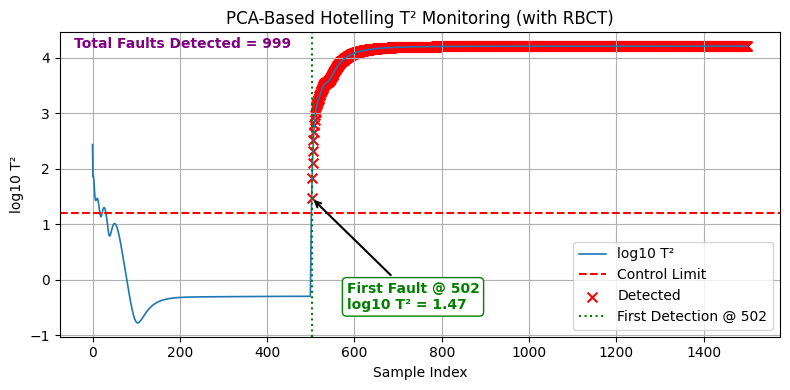

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


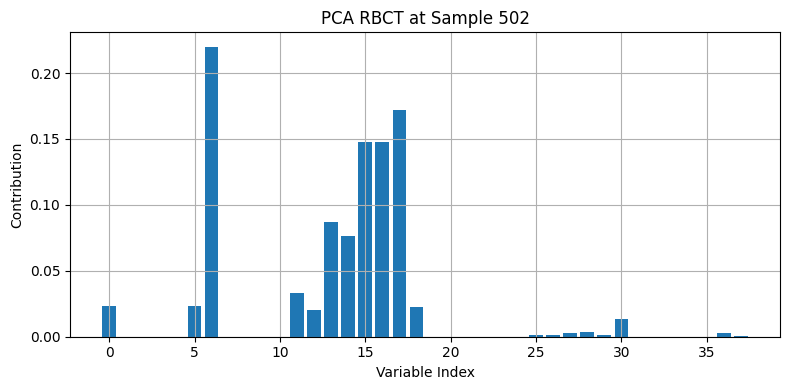

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300
Vpc         = 99
alpha       = 0.01

N, D = dataset4.shape

# ===============================
# Train PCA on first window
# ===============================
X1 = dataset4[:window_size, :]
X1n, mu, sigma = normalize(X1)

Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# ===============================
# Control limit
# ===============================
Cl = compute_control_limit(Np, window_size, alpha)

# ===============================
# Precompute for T² and RBCT
# ===============================
meanY1 = Y1.mean(axis=0)
Cy     = np.cov(Y1, rowvar=False)
invCy  = inv(Cy)

# ---- RBCT matrix (Alcala & Qin) ----
Ms = Pp @ invCy @ Pp.T
Md = np.diag(Ms).copy()
Md[Md < 1e-6] = 1e-6    # numerical safety

# ===============================
# Monitoring
# ===============================
Ts2_all = np.empty(N)
detected = []
RBCT = {}   # key: sample index, value: RBCTk vector

# ---- T² for training window ----
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# ---- T² for online samples ----
for k in range(window_size, N):
    x_norm = (dataset4[k] - mu) / sigma
    yk = x_norm @ Pp
    yk_cent = yk - meanY1

    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

        # ===============================
        # RBCTk (PCA)
        # ===============================
        contrib = (Ms @ x_norm) ** 2 / Md
        RBCT[k] = contrib / (np.sum(contrib) + 1e-8)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# ===============================
# Plot T²
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green',
                           boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,
         f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring (with RBCT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Plot RBCT for first fault
# ===============================
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(D), RBCT[k])
    plt.xlabel('Variable Index')
    plt.ylabel('Contribution')
    plt.title(f'PCA RBCT at Sample {k}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1719354278.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-1719354278.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695

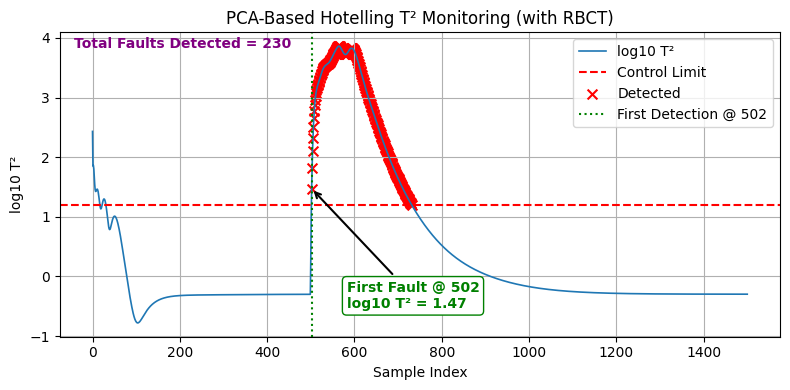

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


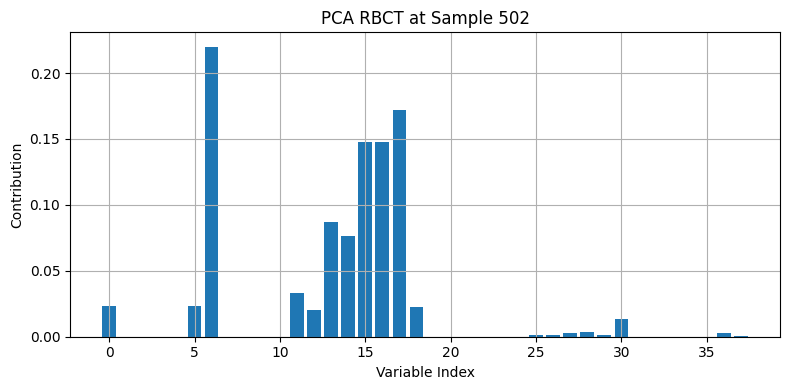

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300
Vpc         = 99
alpha       = 0.01

N, D = dataset3.shape

# ===============================
# Train PCA on first window
# ===============================
X1 = dataset3[:window_size, :]
X1n, mu, sigma = normalize(X1)

Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# ===============================
# Control limit
# ===============================
Cl = compute_control_limit(Np, window_size, alpha)

# ===============================
# Precompute for T² and RBCT
# ===============================
meanY1 = Y1.mean(axis=0)
Cy     = np.cov(Y1, rowvar=False)
invCy  = inv(Cy)

# ---- RBCT matrix (Alcala & Qin) ----
Ms = Pp @ invCy @ Pp.T
Md = np.diag(Ms).copy()
Md[Md < 1e-6] = 1e-6    # numerical safety

# ===============================
# Monitoring
# ===============================
Ts2_all = np.empty(N)
detected = []
RBCT = {}   # key: sample index, value: RBCTk vector

# ---- T² for training window ----
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# ---- T² for online samples ----
for k in range(window_size, N):
    x_norm = (dataset3[k] - mu) / sigma
    yk = x_norm @ Pp
    yk_cent = yk - meanY1

    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

        # ===============================
        # RBCTk (PCA)
        # ===============================
        contrib = (Ms @ x_norm) ** 2 / Md
        RBCT[k] = contrib / (np.sum(contrib) + 1e-8)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# ===============================
# Plot T²
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green',
                           boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring (with RBCT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Plot RBCT for first fault
# ===============================
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(D), RBCT[k])
    plt.xlabel('Variable Index')
    plt.ylabel('Contribution')
    plt.title(f'PCA RBCT at Sample {k}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-404298678.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-404298678.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699

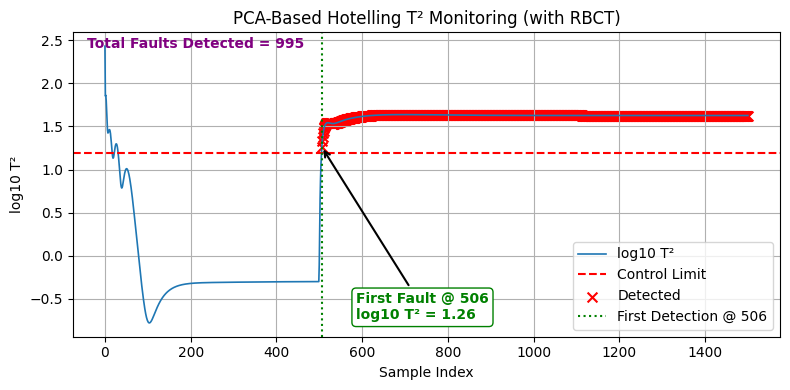

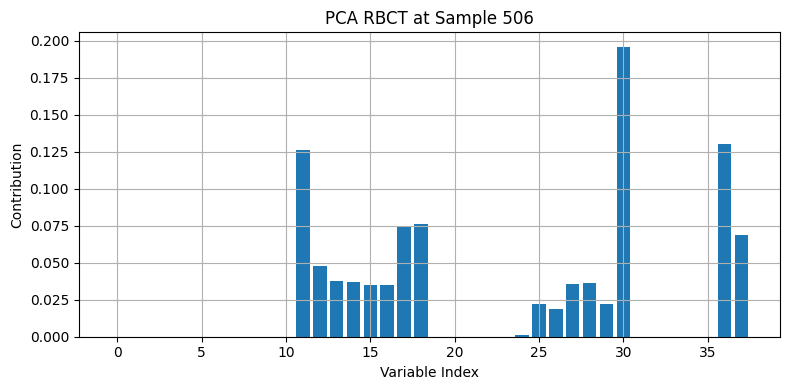

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300
Vpc         = 99
alpha       = 0.01

N, D = dataset2.shape

# ===============================
# Train PCA on first window
# ===============================
X1 = dataset2[:window_size, :]
X1n, mu, sigma = normalize(X1)

Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# ===============================
# Control limit
# ===============================
Cl = compute_control_limit(Np, window_size, alpha)

# ===============================
# Precompute for T² and RBCT
# ===============================
meanY1 = Y1.mean(axis=0)
Cy     = np.cov(Y1, rowvar=False)
invCy  = inv(Cy)

# ---- RBCT matrix (Alcala & Qin) ----
Ms = Pp @ invCy @ Pp.T
Md = np.diag(Ms).copy()
Md[Md < 1e-6] = 1e-6    # numerical safety

# ===============================
# Monitoring
# ===============================
Ts2_all = np.empty(N)
detected = []
RBCT = {}   # key: sample index, value: RBCTk vector

# ---- T² for training window ----
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# ---- T² for online samples ----
for k in range(window_size, N):
    x_norm = (dataset2[k] - mu) / sigma
    yk = x_norm @ Pp
    yk_cent = yk - meanY1

    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

        # ===============================
        # RBCTk (PCA)
        # ===============================
        contrib = (Ms @ x_norm) ** 2 / Md
        RBCT[k] = contrib / (np.sum(contrib) + 1e-8)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# ===============================
# Plot T²
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green',
                           boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring (with RBCT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Plot RBCT for first fault
# ===============================
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(D), RBCT[k])
    plt.xlabel('Variable Index')
    plt.ylabel('Contribution')
    plt.title(f'PCA RBCT at Sample {k}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-2113811251.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)
/tmp/ipython-input-2113811251.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  t2 = float(yk_cent @ invCy @ yk_cent)


Detected anomalies at indices: [506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562]
Total detected: 57


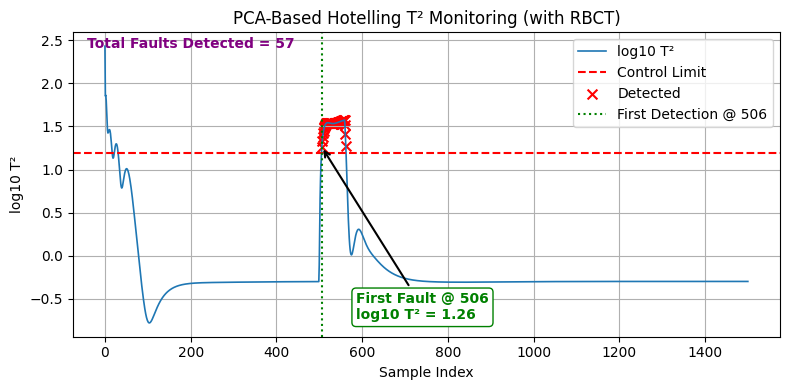

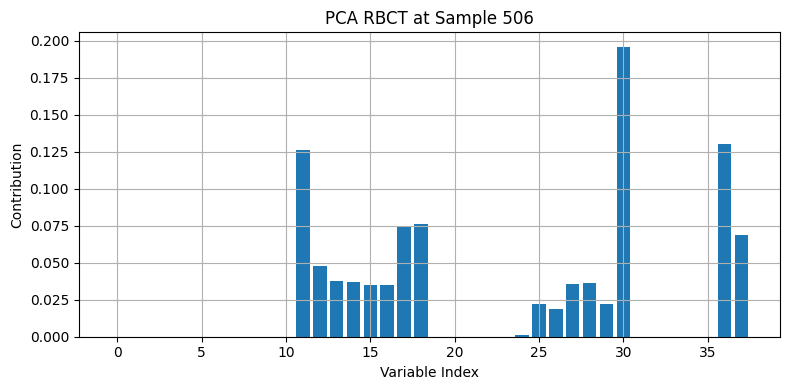

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

window_size = 300
Vpc         = 99
alpha       = 0.01

N, D = dataset1.shape

# ===============================
# Train PCA on first window
# ===============================
X1 = dataset1[:window_size, :]
X1n, mu, sigma = normalize(X1)

Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# ===============================
# Control limit
# ===============================
Cl = compute_control_limit(Np, window_size, alpha)

# ===============================
# Precompute for T² and RBCT
# ===============================
meanY1 = Y1.mean(axis=0)
Cy     = np.cov(Y1, rowvar=False)
invCy  = inv(Cy)

# ---- RBCT matrix (Alcala & Qin) ----
Ms = Pp @ invCy @ Pp.T
Md = np.diag(Ms).copy()
Md[Md < 1e-6] = 1e-6    # numerical safety

# ===============================
# Monitoring
# ===============================
Ts2_all = np.empty(N)
detected = []
RBCT = {}   # key: sample index, value: RBCTk vector

# ---- T² for training window ----
for i in range(window_size):
    yi_cent = Y1[i] - meanY1
    Ts2_all[i] = float(yi_cent @ invCy @ yi_cent)

# ---- T² for online samples ----
for k in range(window_size, N):
    x_norm = (dataset1[k] - mu) / sigma
    yk = x_norm @ Pp
    yk_cent = yk - meanY1

    t2 = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2

    if t2 >= Cl:
        detected.append(k)

        # ===============================
        # RBCTk (PCA)
        # ===============================
        contrib = (Ms @ x_norm) ** 2 / Md
        RBCT[k] = contrib / (np.sum(contrib) + 1e-8)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# ===============================
# Plot T²
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²', linewidth=1.2)
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')

if len(detected) > 0:
    plt.scatter(detected, np.log10(Ts2_all[detected] + 1e-6),
                c='r', marker='x', s=50, label='Detected')

    first_detected = detected[0]
    first_value = np.log10(Ts2_all[first_detected] + 1e-6)

    plt.axvline(first_detected, color='g', linestyle=':', linewidth=1.5,
                label=f'First Detection @ {first_detected}')

    plt.annotate(f'First Fault @ {first_detected}\nlog10 T² = {first_value:.2f}',
                 xy=(first_detected, first_value),
                 xytext=(first_detected + 80, first_value - 2),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                 color='green', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='green',
                           boxstyle='round,pad=0.3'))

plt.text(0.02, 0.95,f'Total Faults Detected = {len(detected)}',
         transform=plt.gca().transAxes,
         fontsize=10, color='purple', fontweight='bold')

plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA-Based Hotelling T² Monitoring (with RBCT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Plot RBCT for first fault
# ===============================
if len(detected) > 0:
    k = detected[0]
    plt.figure(figsize=(8,4))
    plt.bar(range(D), RBCT[k])
    plt.xlabel('Variable Index')
    plt.ylabel('Contribution')
    plt.title(f'PCA RBCT at Sample {k}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Latent Wise RBCTk